# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


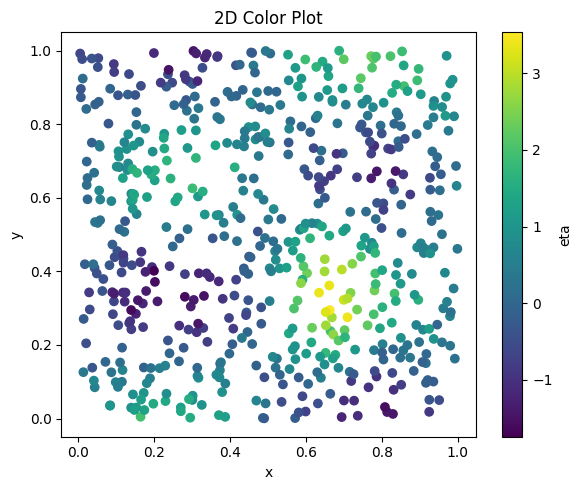

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

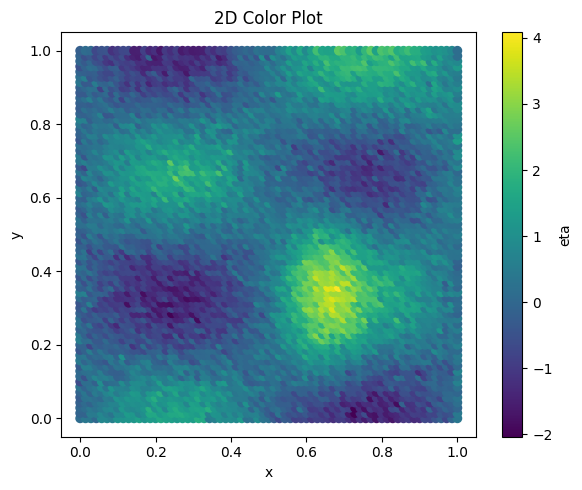

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

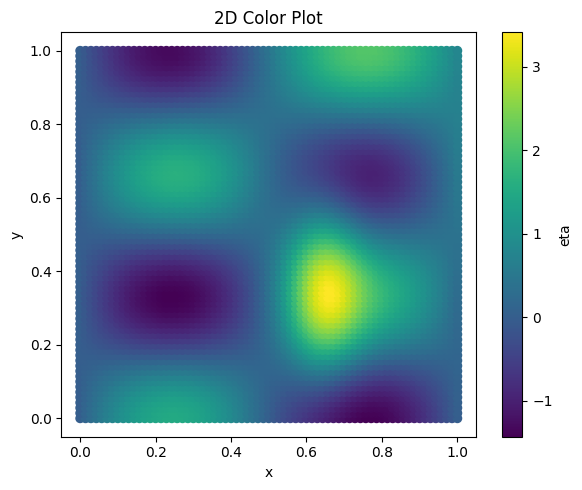

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [9]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [10]:
loc += (
    tb.ti("x", "y", bs="ps", k=10),
    tb.ps("x", k=20),
    tb.ps("y", k=20),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


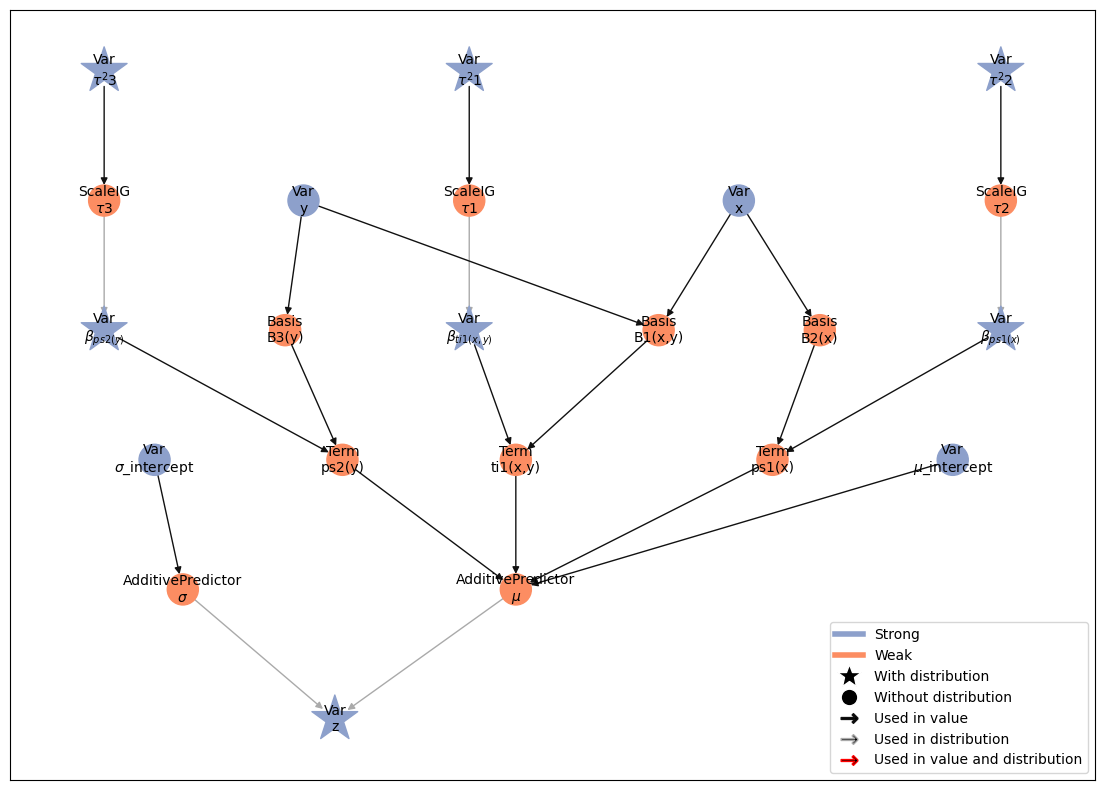

In [11]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

In [12]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ps2(y)}$', '$\\tau^2$3', '$\\beta_{ps1(x)}$', '$\\tau^2$2', '$\\beta_{ti1(x,y)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.53chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 932.90chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1146.92chunk/s]
liesel.g

### MCMC summary

In [13]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_04 -0.009741  0.073212 -0.130014 -0.007991   
                   (1,)   kernel_04  0.001462  0.074444 -0.119202  0.000079   
                   (2,)   kernel_04 -0.013763  0.075780 -0.136426 -0.015336   
                   (3,)   kernel_04  0.035150  0.072093 -0.085931  0.034792   
                   (4,)   kernel_04 -0.025990  0.071268 -0.142054 -0.025504   
...                             ...       ...       ...       ...       ...   
$\mu$_intercept    ()     kernel_01  0.338875  0.011673  0.319829  0.338978   
$\sigma$_intercept ()     kernel_00 -1.345760  0.031775 -1.397422 -1.345784   
$\tau^2$1          ()     kernel_07  0.107209  0.018976  0.079013  0.105542   
$\tau^2$2          ()     kernel_05  0.006452  0.003232  0.002885  0.005732   
$\tau^2$3          ()     kernel_03  0.002312  0.001768  0.000833  0.001855   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{ps1(x)}$   (0,)   0.104147          800  370.023493  526.697144   
                   (1,)   0.130148          800  450.602699  521.651405   
                   (2,)   0.111271          800  454.888315  602.011207   
                   (3,)   0.153909          800  478.016247  616.120724   
                   (4,)   0.084322          800  398.101566  557.352369   
...                            ...          ...         ...         ...   
$\mu$_intercept    ()     0.358696          800  640.217398  534.982424   
$\sigma$_intercept ()    -1.293699          800  435.338715  598.098373   
$\tau^2$1          ()     0.141431          800  336.327184  642.581473   
$\tau^2$2          ()     0.012430          800  403.426407  511.146558   
$\tau^2$3          ()     0.005239          800  293.719224  339.956426   

                              rhat  
parameter          index            
$\beta_{ps1(x)}$   (0,)   1.014204  
                   (1,)   1.004722  
                   (2,)   1.007523  
                   (3,)   1.003663  
                   (4,)   1.009944  
...                            ...  
$\mu$_intercept    ()     1.001209  
$\sigma$_intercept ()     1.008249  
$\tau^2$1          ()     1.008264  
$\tau^2$2          ()     1.003097  
$\tau^2$3          ()     1.018393  

[124 rows x 10 columns]

## Predictions

In [14]:
samples = results.get_posterior_samples()

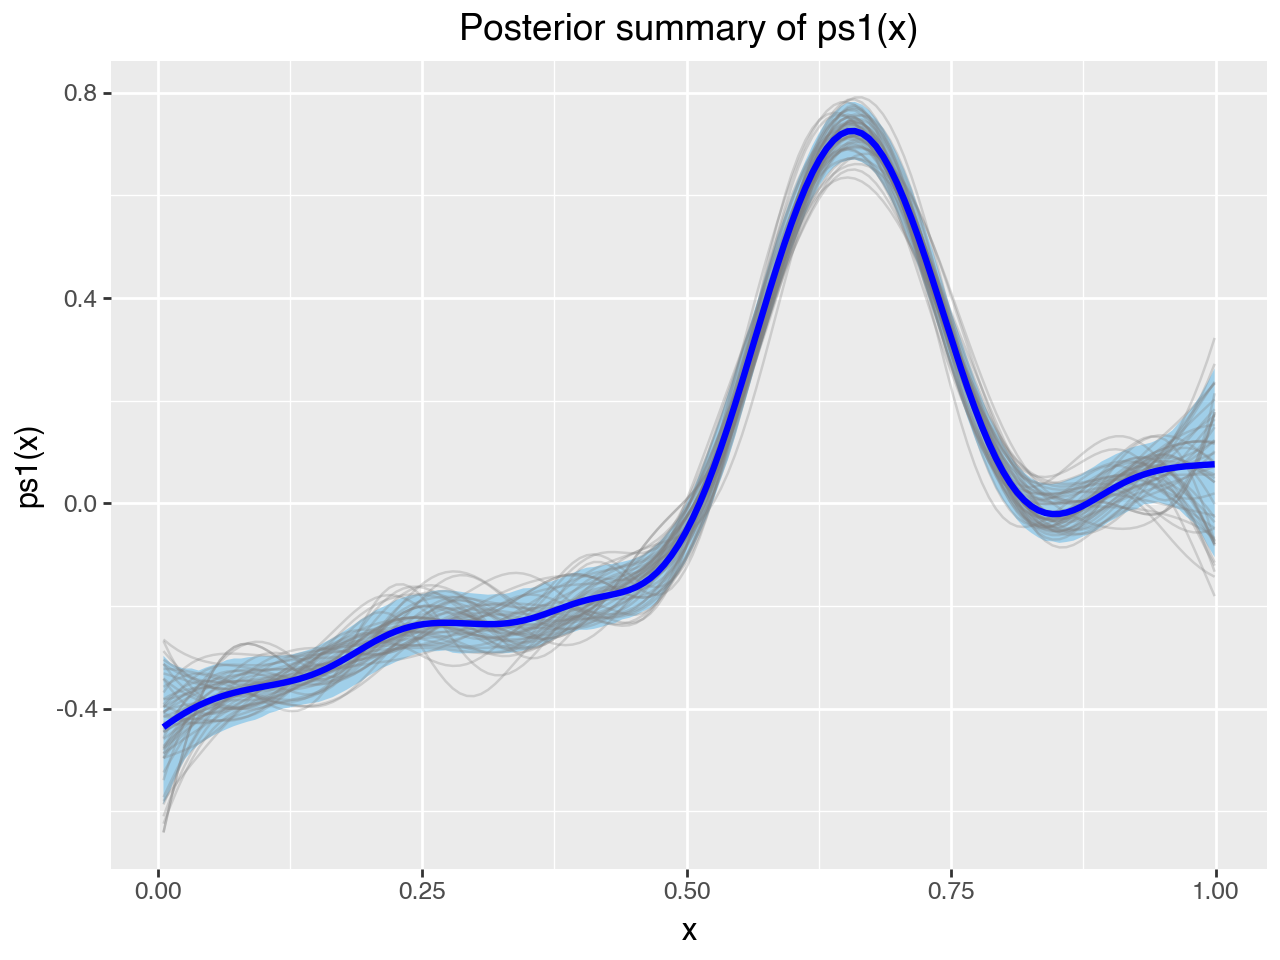

In [15]:
gam.plot_1d_smooth(term=model.vars["ps1(x)"], samples=samples)

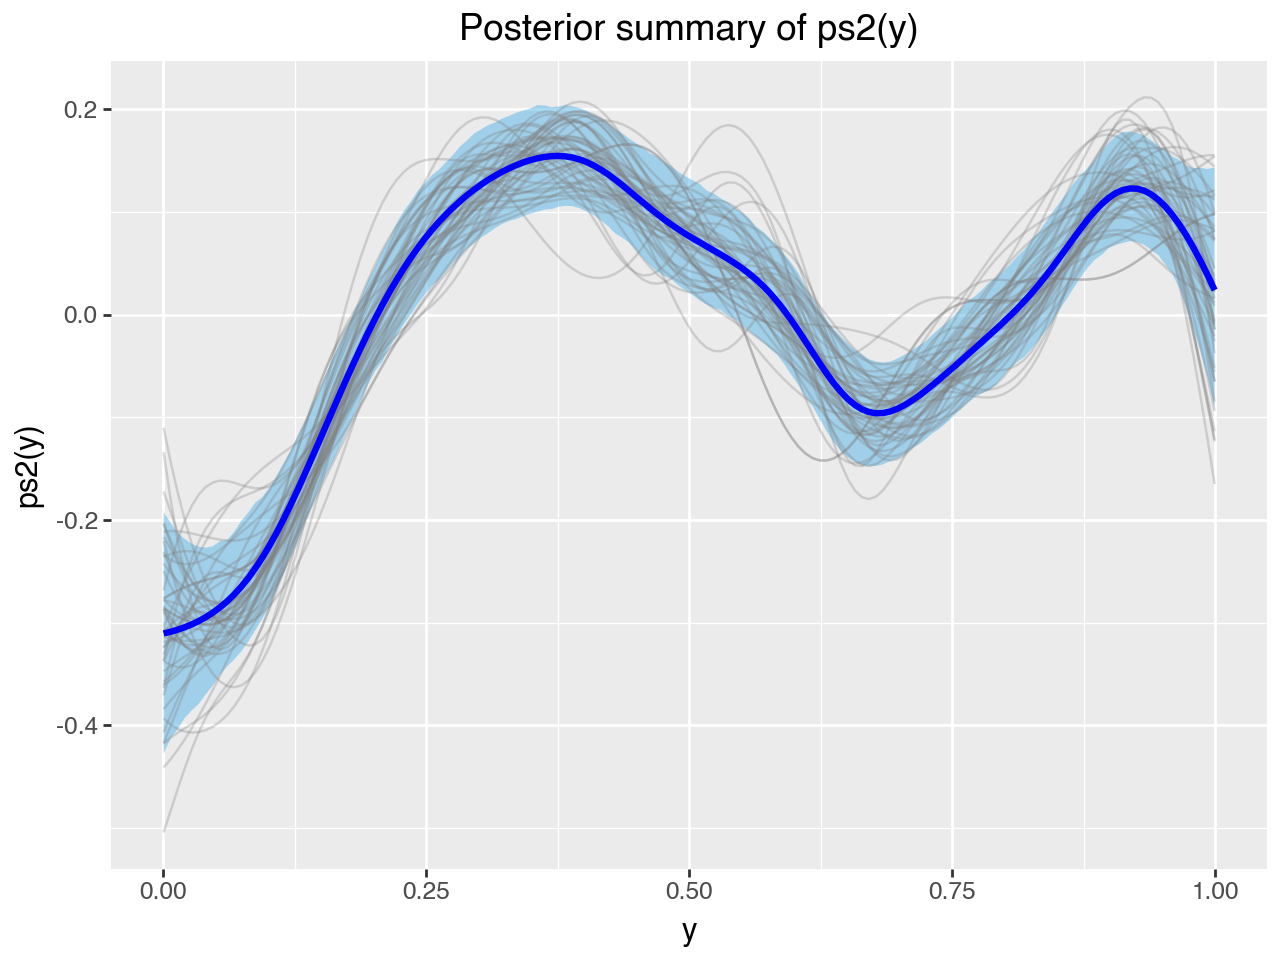

In [16]:
gam.plot_1d_smooth(term=model.vars["ps2(y)"], samples=samples)

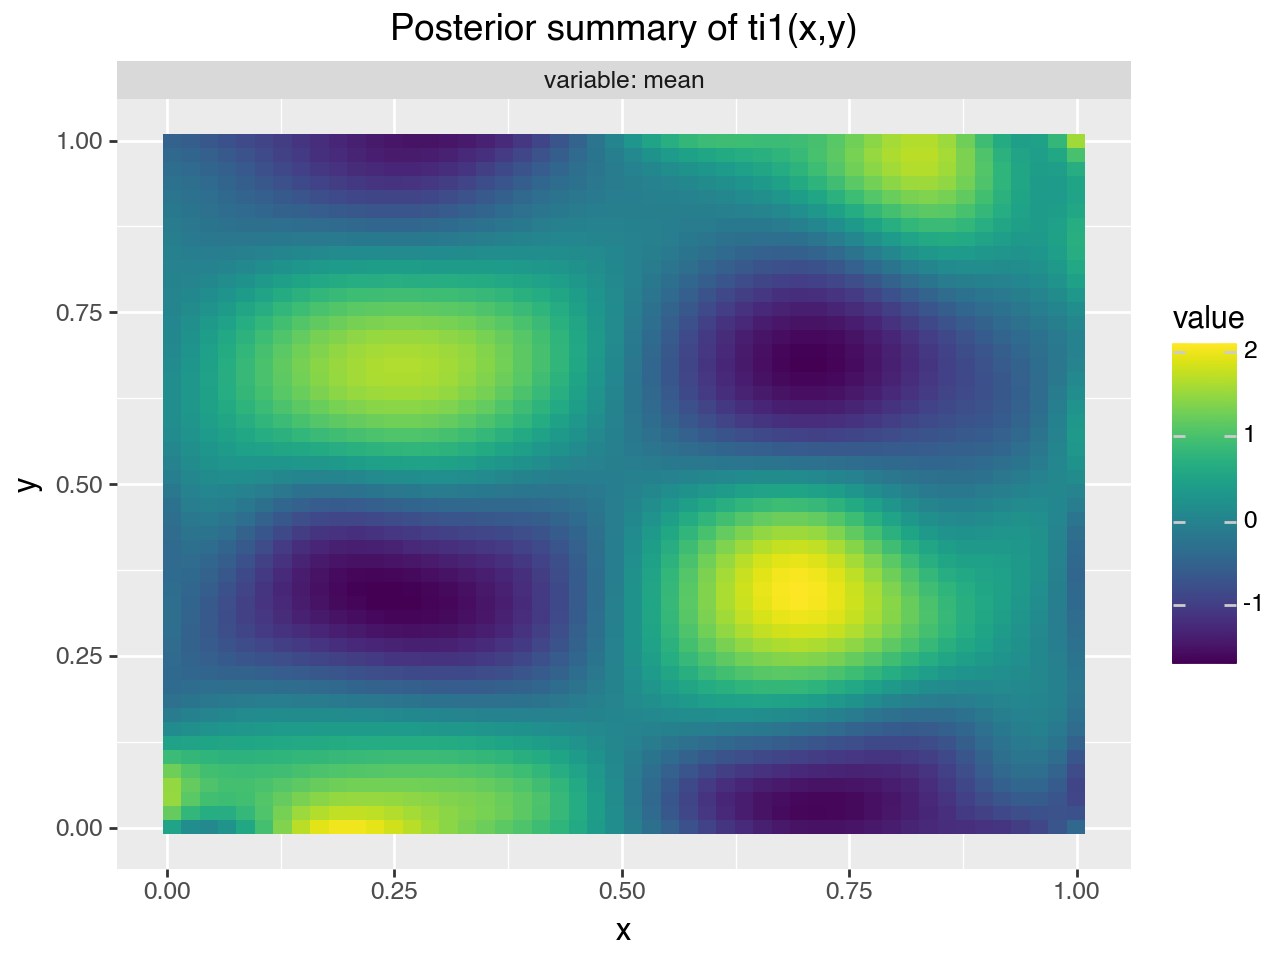

In [17]:
gam.plot_2d_smooth(
    term=loc.terms["ti1(x,y)"],
    samples=samples,
    ngrid=50,
    which=["mean"],
)

### Predict variables at new x values

In [18]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

In [19]:
predictions_summary = gs.SamplesSummary(predictions).to_dataframe().reset_index()
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,0.221670,0.257837,0.507776,76.684073,173.139201,0.058323,0.027040,1.058717,-0.594396,0.197443,1.072912,-0.598537,1.072093,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,-0.109301,0.247526,0.497520,65.718572,149.544227,0.061697,0.027693,1.073569,-0.872047,-0.099212,0.726304,-0.926844,0.653391,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,-0.279379,0.346148,0.588344,77.434988,185.496454,0.067182,0.027327,1.060960,-1.200431,-0.301179,0.726297,-1.213225,0.680803,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,-0.305967,0.428468,0.654574,88.169908,168.693296,0.069963,0.030216,1.051936,-1.310252,-0.346586,0.786002,-1.308965,0.786061,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,-0.215384,0.444352,0.666597,94.787620,143.101004,0.068620,0.031884,1.047531,-1.248072,-0.252693,0.937217,-1.160370,0.999581,0.057143,0.0


### Plot fitted mean

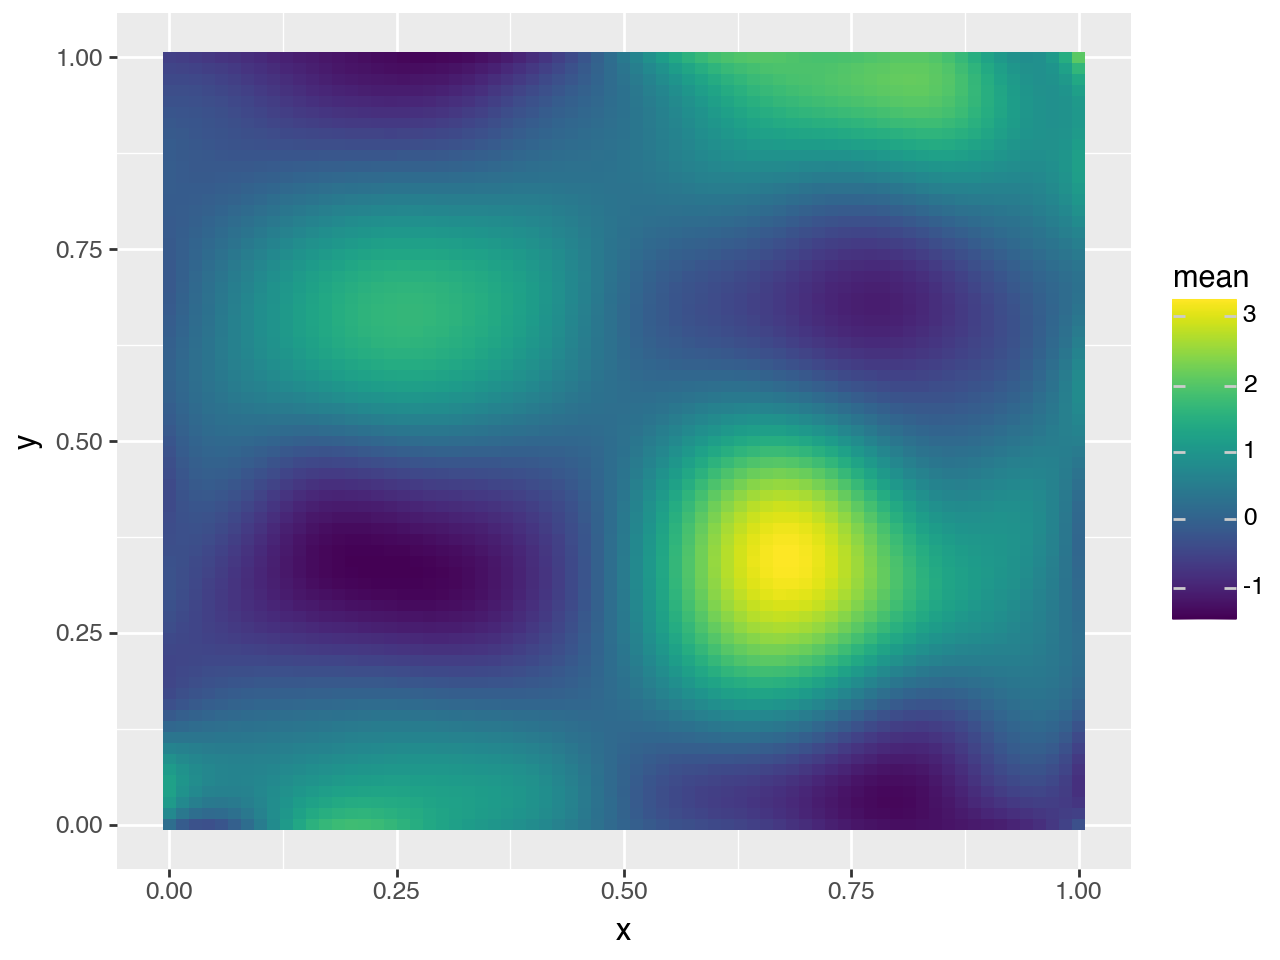

In [20]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))